# File to produce visualizations of CNN models on test data

# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from PIL import Image
from google.colab import drive
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
drive.mount('/content/mydrive', force_remount=True)

Mounted at /content/mydrive


# Load in dataset

In [2]:
directory_path = "/content/mydrive/MyDrive/DeepLearning/MilitaryObjectDetection/archive/crop"
image_count = 0
imgDataset = {"images": [],  "labels": []}

def count_files_in_subdirectories(directory_path):
    subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    subdirectory_counts = {}
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(directory_path, subdirectory)
        files = [f for f in os.listdir(subdirectory_path) if os.path.isfile(os.path.join(subdirectory_path, f))]
        for file in files:
            imgDataset["images"].append(os.path.join(subdirectory_path, file))
            imgDataset["labels"].append(subdirectory)
        subdirectory_counts[subdirectory] = len(files)
    return subdirectory_counts
subdirectory_counts = count_files_in_subdirectories(directory_path)


militaryDf = pd.DataFrame.from_dict(imgDataset)
print(militaryDf.shape)
militaryDf.head()

(19745, 2)


,images,labels
0,/content/mydrive/MyDrive/DeepLearning/Military...,F16
1,/content/mydrive/MyDrive/DeepLearning/Military...,F16
2,/content/mydrive/MyDrive/DeepLearning/Military...,F16
3,/content/mydrive/MyDrive/DeepLearning/Military...,F16
4,/content/mydrive/MyDrive/DeepLearning/Military...,F16


# Load in data into Pytorch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        label = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

from torchvision import transforms
transform_to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a specific size (e.g., 224x224)
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

label_encoder = LabelEncoder()
militaryDf['labels_old'] = militaryDf['labels'].copy(deep=True)
militaryDf['labels'] = label_encoder.fit_transform(militaryDf['labels'])


# Split data into train and test sets
train_df, test_df = train_test_split(militaryDf, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_ds = CustomDataset(train_df['images'], train_df['labels'], transform=transform_to_tensor)
test_ds = CustomDataset(test_df['images'], test_df['labels'], transform=transform_to_tensor)

# Evaluate Each Model on Raw Accuracy

In [4]:
#Model Paths
mod_path = "/content/mydrive/MyDrive/DeepLearning/MilitaryObjectDetection/models"
model_files = ["AlexNet_9.pth", "VGG-16_9.pth",  "ResNet50_9.pth", "ResNet50FPN_9.pth", "ResNet50_19.pth", "ResNet50FPN_19.pth", "VGG-16_19.pth", "AlexNet_9.pth" ]

#Batch Size
batch_size = 32

num_classes = 47 #Number of classes in dataset + 1

model_scores = {"models":[], "accuracy": []}

model_class_accuracy = {"models":[], "class_results": []}
model_class_precision = {"models":[], "class_results": []}

for file in model_files:
    test_loader = DataLoader(test_ds, batch_size=32)
    model_path = os.path.join(mod_path, file)
    print(f"Evaluating {file}")
    if file == 'AlexNet_19.pth' or file == 'AlexNet_9.pth':
        model = models.alexnet(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 47)
    elif file == 'VGG-16_19.pth' or file == 'VGG-16_19.pth':
        model = models.vgg16(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 47)
    elif file == 'ResNet50_19.pth' or file == 'ResNet50_9.pth':
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 47)
    elif file == 'ResNet50FPN_19.pth' or file == 'ResNet50FPN_9.pth':
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 47)
    else:
        print("Model not found")
        continue
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)


    correct = 0
    total = 0

    class_correct = torch.zeros(num_classes)  # num_classes is the total number of classes in your dataset
    class_total = torch.zeros(num_classes)
    class_false_positives = torch.zeros(num_classes)

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            for c in range(num_classes):
              class_mask = labels == c
              class_total[c] += class_mask.sum().item()
              class_correct[c] += (predicted[class_mask] == c).sum().item()
              class_false_positives[c] += (predicted == c).sum().item() - (predicted[class_mask] == c).sum().item()

    class_accuracy = class_correct / class_total
    class_precision = class_correct / (class_correct + class_false_positives + 1e-10)
    print("Class-wise Accuracy:")
    for c in range(num_classes):
      print(f"Class {c} - Accuracy: {class_accuracy[c]:.4f} | Precision: {class_precision[c]:.4f}")



    accuracy = 100 * (correct / total)
    model_scores["models"].append(file)
    model_scores["accuracy"].append(accuracy)
    model_class_accuracy["models"].append(file)
    model_class_accuracy["class_results"].append(class_accuracy)
    model_class_precision["models"].append(file)
    model_class_precision["class_results"].append(class_precision)
    print(f"Accuracy on test set: {accuracy:.2f}%")

Evaluating AlexNet_9.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 105MB/s]
100%|██████████| 124/124 [17:18<00:00,  8.37s/it]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'wei

Class-wise Accuracy:
Class 0 - Accuracy: 0.6786 | Precision: 0.7600
Class 1 - Accuracy: 0.5946 | Precision: 0.8627
Class 2 - Accuracy: 0.7949 | Precision: 0.9118
Class 3 - Accuracy: 0.8846 | Precision: 0.8734
Class 4 - Accuracy: 0.8611 | Precision: 0.5254
Class 5 - Accuracy: 0.8851 | Precision: 0.6471
Class 6 - Accuracy: 0.6190 | Precision: 0.8254
Class 7 - Accuracy: 0.8235 | Precision: 0.8400
Class 8 - Accuracy: 0.7253 | Precision: 0.6735
Class 9 - Accuracy: 0.4792 | Precision: 0.7931
Class 10 - Accuracy: 0.8714 | Precision: 0.6489
Class 11 - Accuracy: 0.4861 | Precision: 0.8974
Class 12 - Accuracy: 0.7941 | Precision: 0.9643
Class 13 - Accuracy: 0.8889 | Precision: 0.7619
Class 14 - Accuracy: 0.4661 | Precision: 0.9167
Class 15 - Accuracy: 0.6885 | Precision: 0.9545
Class 16 - Accuracy: 0.3418 | Precision: 1.0000
Class 17 - Accuracy: 0.4464 | Precision: 0.8333
Class 18 - Accuracy: 0.5091 | Precision: 0.6871
Class 19 - Accuracy: 0.6920 | Precision: 0.5985
Class 20 - Accuracy: 0.3333 |

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.6MB/s]
100%|██████████| 124/124 [00:48<00:00,  2.54it/s]


Class-wise Accuracy:
Class 0 - Accuracy: 0.9464 | Precision: 0.4206
Class 1 - Accuracy: 0.8108 | Precision: 0.7059
Class 2 - Accuracy: 0.9744 | Precision: 0.8085
Class 3 - Accuracy: 0.9231 | Precision: 0.5854
Class 4 - Accuracy: 0.7130 | Precision: 0.8105
Class 5 - Accuracy: 0.8851 | Precision: 0.7700
Class 6 - Accuracy: 0.7738 | Precision: 0.7471
Class 7 - Accuracy: 0.6863 | Precision: 0.9459
Class 8 - Accuracy: 0.5824 | Precision: 0.8983
Class 9 - Accuracy: 0.6771 | Precision: 0.7303
Class 10 - Accuracy: 0.8929 | Precision: 0.7310
Class 11 - Accuracy: 0.4861 | Precision: 0.8750
Class 12 - Accuracy: 0.6618 | Precision: 0.9574
Class 13 - Accuracy: 0.8333 | Precision: 1.0000
Class 14 - Accuracy: 0.3898 | Precision: 0.9583
Class 15 - Accuracy: 0.8852 | Precision: 0.8710
Class 16 - Accuracy: 0.8354 | Precision: 0.5546
Class 17 - Accuracy: 0.6473 | Precision: 0.6621
Class 18 - Accuracy: 0.6000 | Precision: 0.5136
Class 19 - Accuracy: 0.6607 | Precision: 0.7150
Class 20 - Accuracy: 0.8519 |

100%|██████████| 124/124 [00:50<00:00,  2.46it/s]


Class-wise Accuracy:
Class 0 - Accuracy: 0.8929 | Precision: 0.6369
Class 1 - Accuracy: 0.7703 | Precision: 0.6786
Class 2 - Accuracy: 0.9487 | Precision: 0.8810
Class 3 - Accuracy: 0.9103 | Precision: 0.7634
Class 4 - Accuracy: 0.7037 | Precision: 0.8539
Class 5 - Accuracy: 0.8276 | Precision: 0.7826
Class 6 - Accuracy: 0.8571 | Precision: 0.6606
Class 7 - Accuracy: 0.6863 | Precision: 0.9211
Class 8 - Accuracy: 0.7692 | Precision: 0.6422
Class 9 - Accuracy: 0.6771 | Precision: 0.5804
Class 10 - Accuracy: 0.7929 | Precision: 0.9024
Class 11 - Accuracy: 0.6111 | Precision: 0.7458
Class 12 - Accuracy: 0.7353 | Precision: 0.9615
Class 13 - Accuracy: 0.8889 | Precision: 1.0000
Class 14 - Accuracy: 0.5932 | Precision: 0.7865
Class 15 - Accuracy: 0.9180 | Precision: 0.7273
Class 16 - Accuracy: 0.7975 | Precision: 0.6300
Class 17 - Accuracy: 0.6518 | Precision: 0.6577
Class 18 - Accuracy: 0.5136 | Precision: 0.6608
Class 19 - Accuracy: 0.6339 | Precision: 0.7320
Class 20 - Accuracy: 0.6481 |

100%|██████████| 124/124 [00:50<00:00,  2.47it/s]


Class-wise Accuracy:
Class 0 - Accuracy: 0.7321 | Precision: 0.9425
Class 1 - Accuracy: 0.6351 | Precision: 0.9216
Class 2 - Accuracy: 0.9487 | Precision: 0.8222
Class 3 - Accuracy: 0.9359 | Precision: 0.7019
Class 4 - Accuracy: 0.8611 | Precision: 0.7561
Class 5 - Accuracy: 0.8966 | Precision: 0.8387
Class 6 - Accuracy: 0.7262 | Precision: 0.9385
Class 7 - Accuracy: 0.9216 | Precision: 0.7705
Class 8 - Accuracy: 0.7582 | Precision: 0.8313
Class 9 - Accuracy: 0.7396 | Precision: 0.7320
Class 10 - Accuracy: 0.9429 | Precision: 0.8049
Class 11 - Accuracy: 0.7500 | Precision: 0.8852
Class 12 - Accuracy: 0.9559 | Precision: 0.7065
Class 13 - Accuracy: 1.0000 | Precision: 0.6667
Class 14 - Accuracy: 0.5339 | Precision: 0.9000
Class 15 - Accuracy: 0.9180 | Precision: 0.9655
Class 16 - Accuracy: 0.8354 | Precision: 0.6667
Class 17 - Accuracy: 0.6295 | Precision: 0.8393
Class 18 - Accuracy: 0.7273 | Precision: 0.4923
Class 19 - Accuracy: 0.6473 | Precision: 0.7474
Class 20 - Accuracy: 0.8426 |

100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class-wise Accuracy:
Class 0 - Accuracy: 0.8929 | Precision: 0.7937
Class 1 - Accuracy: 0.4730 | Precision: 0.9722
Class 2 - Accuracy: 0.9744 | Precision: 1.0000
Class 3 - Accuracy: 0.8974 | Precision: 0.8333
Class 4 - Accuracy: 0.7778 | Precision: 0.9231
Class 5 - Accuracy: 0.9885 | Precision: 0.7167
Class 6 - Accuracy: 0.6548 | Precision: 0.9322
Class 7 - Accuracy: 0.8431 | Precision: 0.9348
Class 8 - Accuracy: 0.8626 | Precision: 0.6488
Class 9 - Accuracy: 0.7083 | Precision: 0.7640
Class 10 - Accuracy: 0.8929 | Precision: 0.8993
Class 11 - Accuracy: 0.8472 | Precision: 0.8133
Class 12 - Accuracy: 0.7353 | Precision: 0.9615
Class 13 - Accuracy: 1.0000 | Precision: 0.7826
Class 14 - Accuracy: 0.8136 | Precision: 0.5680
Class 15 - Accuracy: 0.9344 | Precision: 0.9194
Class 16 - Accuracy: 0.7722 | Precision: 0.8243
Class 17 - Accuracy: 0.4732 | Precision: 0.9298
Class 18 - Accuracy: 0.3818 | Precision: 0.8842
Class 19 - Accuracy: 0.8080 | Precision: 0.5801
Class 20 - Accuracy: 0.6852 |

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 130MB/s]
100%|██████████| 124/124 [00:57<00:00,  2.15it/s]


Class-wise Accuracy:
Class 0 - Accuracy: 0.5268 | Precision: 0.8806
Class 1 - Accuracy: 0.7027 | Precision: 0.8125
Class 2 - Accuracy: 0.8462 | Precision: 0.8462
Class 3 - Accuracy: 0.8077 | Precision: 0.7683
Class 4 - Accuracy: 0.8148 | Precision: 0.6822
Class 5 - Accuracy: 0.7471 | Precision: 0.9028
Class 6 - Accuracy: 0.8452 | Precision: 0.3287
Class 7 - Accuracy: 0.7059 | Precision: 0.9000
Class 8 - Accuracy: 0.5220 | Precision: 0.8482
Class 9 - Accuracy: 0.5000 | Precision: 0.5783
Class 10 - Accuracy: 0.8500 | Precision: 0.6879
Class 11 - Accuracy: 0.3194 | Precision: 0.9583
Class 12 - Accuracy: 0.9118 | Precision: 0.7949
Class 13 - Accuracy: 0.9444 | Precision: 0.8947
Class 14 - Accuracy: 0.5847 | Precision: 0.7041
Class 15 - Accuracy: 0.8852 | Precision: 0.8308
Class 16 - Accuracy: 0.5696 | Precision: 0.6081
Class 17 - Accuracy: 0.6339 | Precision: 0.4537
Class 18 - Accuracy: 0.5909 | Precision: 0.5159
Class 19 - Accuracy: 0.5134 | Precision: 0.7233
Class 20 - Accuracy: 0.7778 |

100%|██████████| 124/124 [00:39<00:00,  3.10it/s]

Class-wise Accuracy:
Class 0 - Accuracy: 0.6786 | Precision: 0.7600
Class 1 - Accuracy: 0.5946 | Precision: 0.8627
Class 2 - Accuracy: 0.7949 | Precision: 0.9118
Class 3 - Accuracy: 0.8846 | Precision: 0.8734
Class 4 - Accuracy: 0.8611 | Precision: 0.5254
Class 5 - Accuracy: 0.8851 | Precision: 0.6471
Class 6 - Accuracy: 0.6190 | Precision: 0.8254
Class 7 - Accuracy: 0.8235 | Precision: 0.8400
Class 8 - Accuracy: 0.7253 | Precision: 0.6735
Class 9 - Accuracy: 0.4792 | Precision: 0.7931
Class 10 - Accuracy: 0.8714 | Precision: 0.6489
Class 11 - Accuracy: 0.4861 | Precision: 0.8974
Class 12 - Accuracy: 0.7941 | Precision: 0.9643
Class 13 - Accuracy: 0.8889 | Precision: 0.7619
Class 14 - Accuracy: 0.4661 | Precision: 0.9167
Class 15 - Accuracy: 0.6885 | Precision: 0.9545
Class 16 - Accuracy: 0.3418 | Precision: 1.0000
Class 17 - Accuracy: 0.4464 | Precision: 0.8333
Class 18 - Accuracy: 0.5091 | Precision: 0.6871
Class 19 - Accuracy: 0.6920 | Precision: 0.5985
Class 20 - Accuracy: 0.3333 |

# Plotting Results By Class

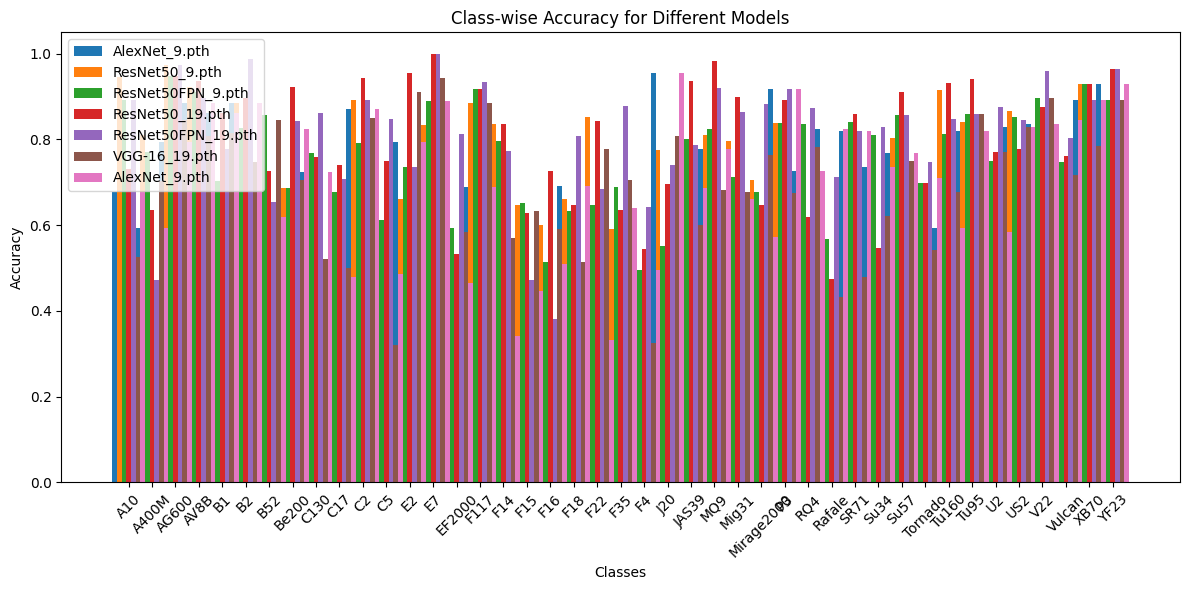

In [6]:
# Print Accuracy
militaryDf = pd.DataFrame.from_dict(imgDataset)
label_encoder = label_encoder.fit(militaryDf['labels'])
class_names = label_encoder.inverse_transform([i for i in range(43)])  # Use only the first 43 classes

bar_width = 0.2
index = np.arange(43)  # Change the number of classes to 43

plt.figure(figsize=(12, 6))

# Plotting class accuracies for each model
for i, model in enumerate(model_class_accuracy["models"]):
    acc_values = model_class_accuracy["class_results"][i][:43]  # Use only the first 43 accuracy values
    plt.bar(index + i * bar_width, acc_values, bar_width, label=model)

plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy for Different Models')
plt.xticks(index + (len(model_class_accuracy["models"]) - 1) * bar_width / 2, class_names,rotation=45)
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()


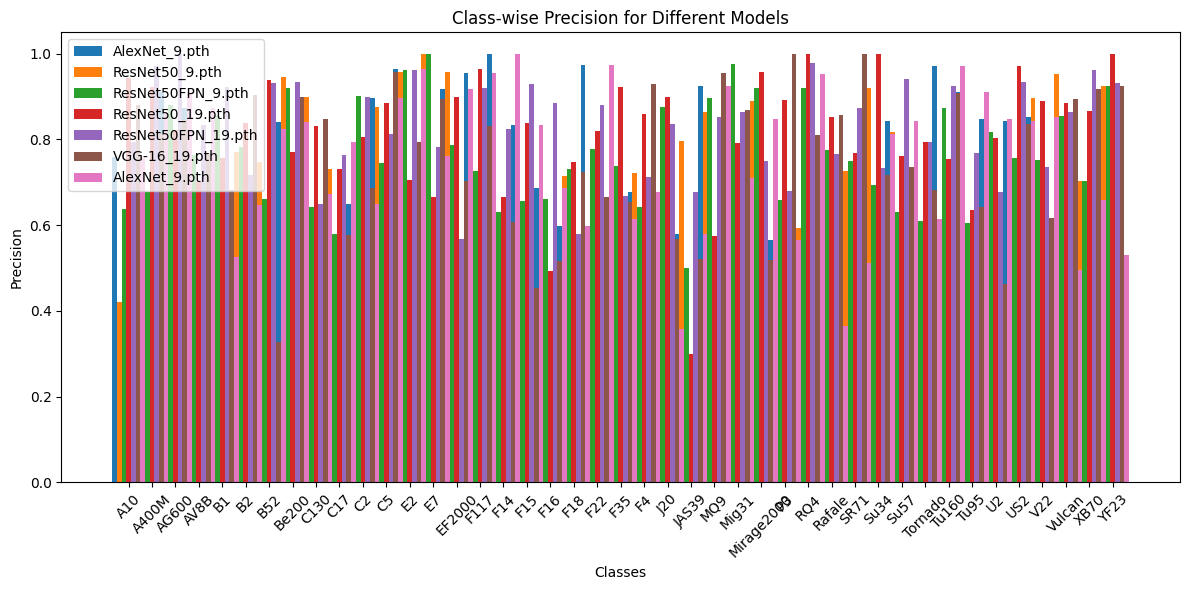

In [7]:
# For precision
bar_width = 0.2
index = np.arange(43)  # Change the number of classes to 43

plt.figure(figsize=(12, 6))

# Plotting class accuracies for each model
for i, model in enumerate(model_class_precision["models"]):
    pre_values = model_class_precision["class_results"][i][:43]  # Use only the first 43 accuracy values
    plt.bar(index + i * bar_width, pre_values, bar_width, label=model)

plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Class-wise Precision for Different Models')
plt.xticks(index + (len(model_class_precision["models"]) - 1) * bar_width / 2, class_names,rotation=45)
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

# Finding Classes with Low Preformance for each model

- Performance Metric
-Accuracy and/or Precision less than 60 percent


In [8]:
for j, model in enumerate(model_class_precision["models"]):
    print("--------------------------------------------------------")
    print(f"Model {model}:")
    acc_less_than_60_indices = [i for i, acc in enumerate(model_class_accuracy["class_results"][j][:43]) if acc < 0.6]
    labels_acc = label_encoder.inverse_transform(acc_less_than_60_indices)
    prec_less_than_60_indices = [i for i, prec in enumerate(model_class_precision["class_results"][j][:43]) if prec < 0.6]
    labels_prec = label_encoder.inverse_transform(prec_less_than_60_indices)



    print("Class with accuracy less than 60%:")
    if(len(acc_less_than_60_indices) == 0):
        print("None")
    for idx, ref in enumerate(acc_less_than_60_indices):
        acc = model_class_accuracy["class_results"][j][ref]
        print(f"Class {labels_acc[idx]} - Accuracy: {acc*100:.2f}%")

    print()
    print("\nClass with precision less than 60%:")
    for idx, ref in enumerate(prec_less_than_60_indices):
        prec = model_class_precision["class_results"][j][ref]
        print(f"Class {labels_prec[idx]} - Precision: {prec*100:.2f}%")
    print()
    print()

--------------------------------------------------------
Model AlexNet_9.pth:
Class with accuracy less than 60%:
Class A400M - Accuracy: 59.46%
Class C17 - Accuracy: 47.92%
Class C5 - Accuracy: 48.61%
Class EF2000 - Accuracy: 46.61%
Class F14 - Accuracy: 34.18%
Class F15 - Accuracy: 44.64%
Class F16 - Accuracy: 50.91%
Class F22 - Accuracy: 33.33%
Class F4 - Accuracy: 49.59%
Class Mirage2000 - Accuracy: 57.35%
Class Tu160 - Accuracy: 59.32%
Class U2 - Accuracy: 58.33%


Class with precision less than 60%:
Class B1 - Precision: 52.54%
Class F18 - Precision: 59.85%
Class J20 - Precision: 35.86%
Class JAS39 - Precision: 57.89%
Class P3 - Precision: 56.67%
Class Rafale - Precision: 36.53%
Class SR71 - Precision: 51.25%
Class Vulcan - Precision: 49.59%
Class YF23 - Precision: 53.06%


--------------------------------------------------------
Model ResNet50_9.pth:
Class with accuracy less than 60%:
Class C130 - Accuracy: 58.24%
Class C5 - Accuracy: 48.61%
Class EF2000 - Accuracy: 38.98%
Class 

# Overall model performance

In [9]:
#Printing out Precision
print("--------------------------------------------------------")
print("Overall Performance")
print("--------------------------------------------------------")
print("Average Precision:")
for j, model in enumerate(model_class_precision["models"]):
    prec_scores = model_class_precision["class_results"][j][:43]
    avg_precision = sum(prec_scores) / len(prec_scores)
    print(f"Model {model} - Average Precision: {avg_precision:.4f}")

print()
#Printing out Accuracy
print("Accuracy:")
for j, model in enumerate(model_scores["models"]):
    score = model_scores["accuracy"][j]
    print(f"Model {model} - Accuracy: {score:.4f}")
print("--------------------------------------------------------")
print("Overall Performance - end of analysis")
print("--------------------------------------------------------")


--------------------------------------------------------
Overall Performance
--------------------------------------------------------
Average Precision:
Model AlexNet_9.pth - Average Precision: 0.7543
Model ResNet50_9.pth - Average Precision: 0.7634
Model ResNet50FPN_9.pth - Average Precision: 0.7642
Model ResNet50_19.pth - Average Precision: 0.8122
Model ResNet50FPN_19.pth - Average Precision: 0.8253
Model VGG-16_19.pth - Average Precision: 0.7538
Model AlexNet_9.pth - Average Precision: 0.7543

Accuracy:
Model AlexNet_9.pth - Accuracy: 67.7387
Model ResNet50_9.pth - Accuracy: 70.8787
Model ResNet50FPN_9.pth - Accuracy: 72.8539
Model ResNet50_19.pth - Accuracy: 75.9433
Model ResNet50FPN_19.pth - Accuracy: 77.7412
Model VGG-16_19.pth - Accuracy: 66.8777
Model AlexNet_9.pth - Accuracy: 67.7387
--------------------------------------------------------
Overall Performance - end of analysis
--------------------------------------------------------
